# QRT ENS Challenge Data 2023 - Benchmark

Version 1 - Boosting, Feature engeneering & XGBoost 

## Librairies

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from joblib import dump

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

C:\Users\monde\AppData\Local\Temp\ipykernel_14984\3705603214.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Chargement des données

- `X_train` et `X_test` ont  $35$ colonnes qui représentent les même variables explicatives mais sur des périodes de temps différentes. 

- `X_train` et `Y_train` partagent la même colonne `ID` - chaque ligne a un ID unique associé à un jour et à un pays. 

- La variable cible `TARGET` de `Y_train` correspond à la variation de prix journalière des futures sur l'électricité (maturité 24h).

- **On notera que certaines colonnes ont des valeurs manquantes**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('../data/X_train.csv')
Y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [3]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [4]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Feature engineering
The main goal here is to reconstruct some of the lost time dimension to create stationary features.

In general we had added statistics, technical indicators, seasonality, clusters and bag of features.

In [5]:
def slope(y):
    return np.polyfit(range(len(y)), y, 1)[0] if len(y) > 0 else np.nan

def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    
    bollinger_upper = sma + (std * 2)
    bollinger_lower = sma - (std * 2)
    
    return bollinger_upper, bollinger_lower

In [6]:
def feature_engineering(X, scaler, training):
    df = X.copy()
    df['COUNTRY'] = df['COUNTRY'].map({'DE': 0, 'FR': 1})
    df.fillna(0, inplace=True)
    
    # Temporal window
    windows = [7, 30]

    # Column to calculate statistic
    variables = ['CONSUMPTION', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'TEMP', 'RAIN', 'WIND']
    
    def slope(y):
        return np.polyfit(range(len(y)), y, 1)[0] if len(y) > 0 else np.nan

    for var in variables:
        for window in windows:
            for country in ['DE_', 'FR_']:
                # Mean, Standard deviation, Median, Minimum, Maximum, Slope
                df[f'{country}{var}_MEAN_{window}D'] = df[f'{country}{var}'].rolling(window=window).mean()
                df[f'{country}{var}_STD_{window}D'] = df[f'{country}{var}'].rolling(window=window).std()
                df[f'{country}{var}_MEDIAN_{window}D'] = df[f'{country}{var}'].rolling(window=window).median()
                df[f'{country}{var}_MIN_{window}D'] = df[f'{country}{var}'].rolling(window=window).min()
                df[f'{country}{var}_MAX_{window}D'] = df[f'{country}{var}'].rolling(window=window).max()
                df[f'{country}{var}_SLOPE_{window}D'] = df[f'{country}{var}'].rolling(window=window).apply(slope, raw=True)

                # Additional features based on the original request
                if var in ['CONSUMPTION', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']:  # For RSI and Bollinger Bands
                    df[f'{country}{var}_RSI'] = calculate_rsi(df[f'{country}{var}'])
                    df[f'{country}{var}_BB_UPPER'], df[f'{country}{var}_BB_LOWER'] = calculate_bollinger_bands(df[f'{country}{var}'])
    
    # Seasonality Features
    days_in_year = 365.25
    df['SIN_YEAR'] = np.sin(2 * np.pi * df['DAY_ID'] / days_in_year)
    df['COS_YEAR'] = np.cos(2 * np.pi * df['DAY_ID'] / days_in_year)
    
    days_in_week = 7
    df['SIN_WEEK'] = np.sin(2 * np.pi * df['DAY_ID'] / days_in_week)
    df['COS_WEEK'] = np.cos(2 * np.pi * df['DAY_ID'] / days_in_week)

    df['SEASON'] = pd.cut(df['DAY_ID'] % 365, 
                          bins=[0, 79, 172, 264, 365], 
                          labels=[0, 1, 2, 3],
                          right=False).astype(int)
    
    for energy_source in ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'LIGNITE']:
        df[f'DE_{energy_source}_RATIO'] = df[f'DE_{energy_source}'] / (df['DE_GAS'] + df['DE_COAL'] + df['DE_HYDRO'] + df['DE_NUCLEAR'] + df['DE_SOLAR'] + df['DE_WINDPOW'] + df['DE_LIGNITE'])

    df['DE_IMPORT_RATIO'] = df['DE_NET_IMPORT'] / df['DE_CONSUMPTION']
    df['DE_EXPORT_RATIO'] = df['DE_NET_EXPORT'] / (df['DE_GAS'] + df['DE_COAL'] + df['DE_HYDRO'] + df['DE_NUCLEAR'] + df['DE_SOLAR'] + df['DE_WINDPOW'] + df['DE_LIGNITE'])

    df['DE_FR_NET_EXCHANGE'] = df['DE_FR_EXCHANGE'] - df['FR_DE_EXCHANGE']

    df['DE_WIND_SOLAR'] = df['DE_WINDPOW'] + df['DE_SOLAR']
    df['DE_TEMP_EFFECT'] = df['DE_TEMP'] * df['DE_CONSUMPTION']
    df['DE_WIND_EFFECT'] = df['DE_WIND'] * df['DE_WINDPOW']
    df['DE_SOLAR_EFFECT'] = (df['DE_SOLAR'] / df['DE_TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)

    for commodity in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        df[f'{commodity}_VOLATILITY_7D'] = df[commodity].rolling(window=7).std()
        df[f'{commodity}_VOLATILITY_30D'] = df[commodity].rolling(window=30).std()

    for commodity in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        df[f'{commodity}_EMA_30D'] = df[commodity].ewm(span=30, adjust=False).mean()

    df['DE_RESIDUAL_LOAD_RATIO'] = df['DE_RESIDUAL_LOAD'] / df['DE_CONSUMPTION']
    df['DE_Imbalance'] = (df['DE_GAS'] + df['DE_COAL'] + df['DE_HYDRO'] + df['DE_NUCLEAR'] + df['DE_SOLAR'] + df['DE_WINDPOW'] + df['DE_LIGNITE']) - df['DE_CONSUMPTION'] - df['DE_NET_EXPORT']
    
    for energy_source in ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']:
        df[f'FR_{energy_source}_RATIO'] = df[f'FR_{energy_source}'] / (df['FR_GAS'] + df['FR_COAL'] + df['FR_HYDRO'] + df['FR_NUCLEAR'] + df['FR_SOLAR'] + df['FR_WINDPOW'])

    df['FR_IMPORT_RATIO'] = df['FR_NET_IMPORT'] / df['FR_CONSUMPTION']
    df['FR_EXPORT_RATIO'] = df['FR_NET_EXPORT'] / (df['FR_GAS'] + df['FR_COAL'] + df['FR_HYDRO'] + df['FR_NUCLEAR'] + df['FR_SOLAR'] + df['FR_WINDPOW'])

    df['FR_WIND_SOLAR'] = df['FR_WINDPOW'] + df['FR_SOLAR']
    df['FR_TEMP_EFFECT'] = df['FR_TEMP'] * df['FR_CONSUMPTION']
    df['FR_WIND_EFFECT'] = df['FR_WIND'] * df['FR_WINDPOW']
    df['FR_SOLAR_EFFECT'] = (df['FR_SOLAR'] / df['FR_TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)

    df['FR_WIND_SOLAR'] = df['FR_WINDPOW'] + df['FR_SOLAR']
    df['FR_TEMP_EFFECT'] = df['FR_TEMP'] * df['FR_CONSUMPTION']
    df['FR_WIND_EFFECT'] = df['FR_WIND'] * df['FR_WINDPOW']
    df['FR_SOLAR_EFFECT'] = (df['FR_SOLAR'] / df['FR_TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)

    df['FR_RESIDUAL_LOAD_RATIO'] = df['FR_RESIDUAL_LOAD'] / df['FR_CONSUMPTION']
    df['FR_Imbalance'] = (df['FR_GAS'] + df['FR_COAL'] + df['FR_HYDRO'] + df['FR_NUCLEAR'] + df['FR_SOLAR'] + df['FR_WINDPOW']) - df['FR_CONSUMPTION'] - df['FR_NET_EXPORT']
    
    df.fillna(method='bfill', inplace=True)
    if training:
        df_scaled = scaler.fit_transform(df)
    else:
        df_scaled = scaler.transform(df)
    
    # Adjust 'n_clusters' based on your dataset and experimentation
    kmeans = KMeans(n_clusters=10, random_state=42)
    df['cluster'] = kmeans.fit_predict(df_scaled)
    
    # Creating bag of features based on cluster means/medians
    for cluster in df['cluster'].unique():
        cluster_mask = df['cluster'] == cluster
        for var in variables:
            for country in ['DE_', 'FR_']:
                cluster_mean = df.loc[cluster_mask, country+var].mean()
                cluster_median = df.loc[cluster_mask, country+var].median()
                df[f'{country}{var}_cluster_{cluster}_mean_diff'] = df[country+var] - cluster_mean
                df[f'{country}{var}_cluster_{cluster}_median_diff'] = df[country+var] - cluster_median
    
    # Différenciation par rapport à la moyenne mobile
    for var in variables:
        for country in ['DE_', 'FR_']:
            df[f'{country}{var}_diff_ma2'] = df[country+var] - df[country+var].rolling(window=2).mean()
            df[f'{country}{var}_diff_ma5'] = df[country+var] - df[country+var].rolling(window=5).mean()
    
    # Ensuring all missing data filled if any new were created
    df.fillna(method='bfill', inplace=True)

    return df

#### *Apply the feature engineering to the df*

In [7]:
scaler = StandardScaler()
X_featurized = feature_engineering(X_train, scaler, True)
print(f"Final number of columns: {len(X_featurized.columns)}")

Final number of columns: 802


#### *Check the stationarity of all features*

In [8]:
def test_stationarity(df):
    results = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            adf_test = adfuller(df[column].dropna(), autolag='AIC')
            results[column] = {'Test Statistic': adf_test[0], 
                               'p-value': adf_test[1], 
                               'Used Lag': adf_test[2], 
                               'Number of Observations Used': adf_test[3], 
                               'Critical Values': adf_test[4], 
                               'Stationary': adf_test[1] < 0.05}
    return results

def check_stationarity(stationarity_results):
    non_stationary_features = {feature: result for feature, result in stationarity_results.items() if not result['Stationary']}
    
    if non_stationary_features:
        print("Features non stationnaires détectées :")
        for feature, result in non_stationary_features.items():
            print(f"  Feature: {feature}")
            print(f"    Test Statistic: {result['Test Statistic']}")
            print(f"    p-value: {result['p-value']}")
            print(f"    Stationary: {result['Stationary']}")
            print("\n")
    else:
        print("All features are stationary.")

In [9]:
stationarity_results = test_stationarity(X_featurized)
check_stationarity(stationarity_results)

All features are stationary.


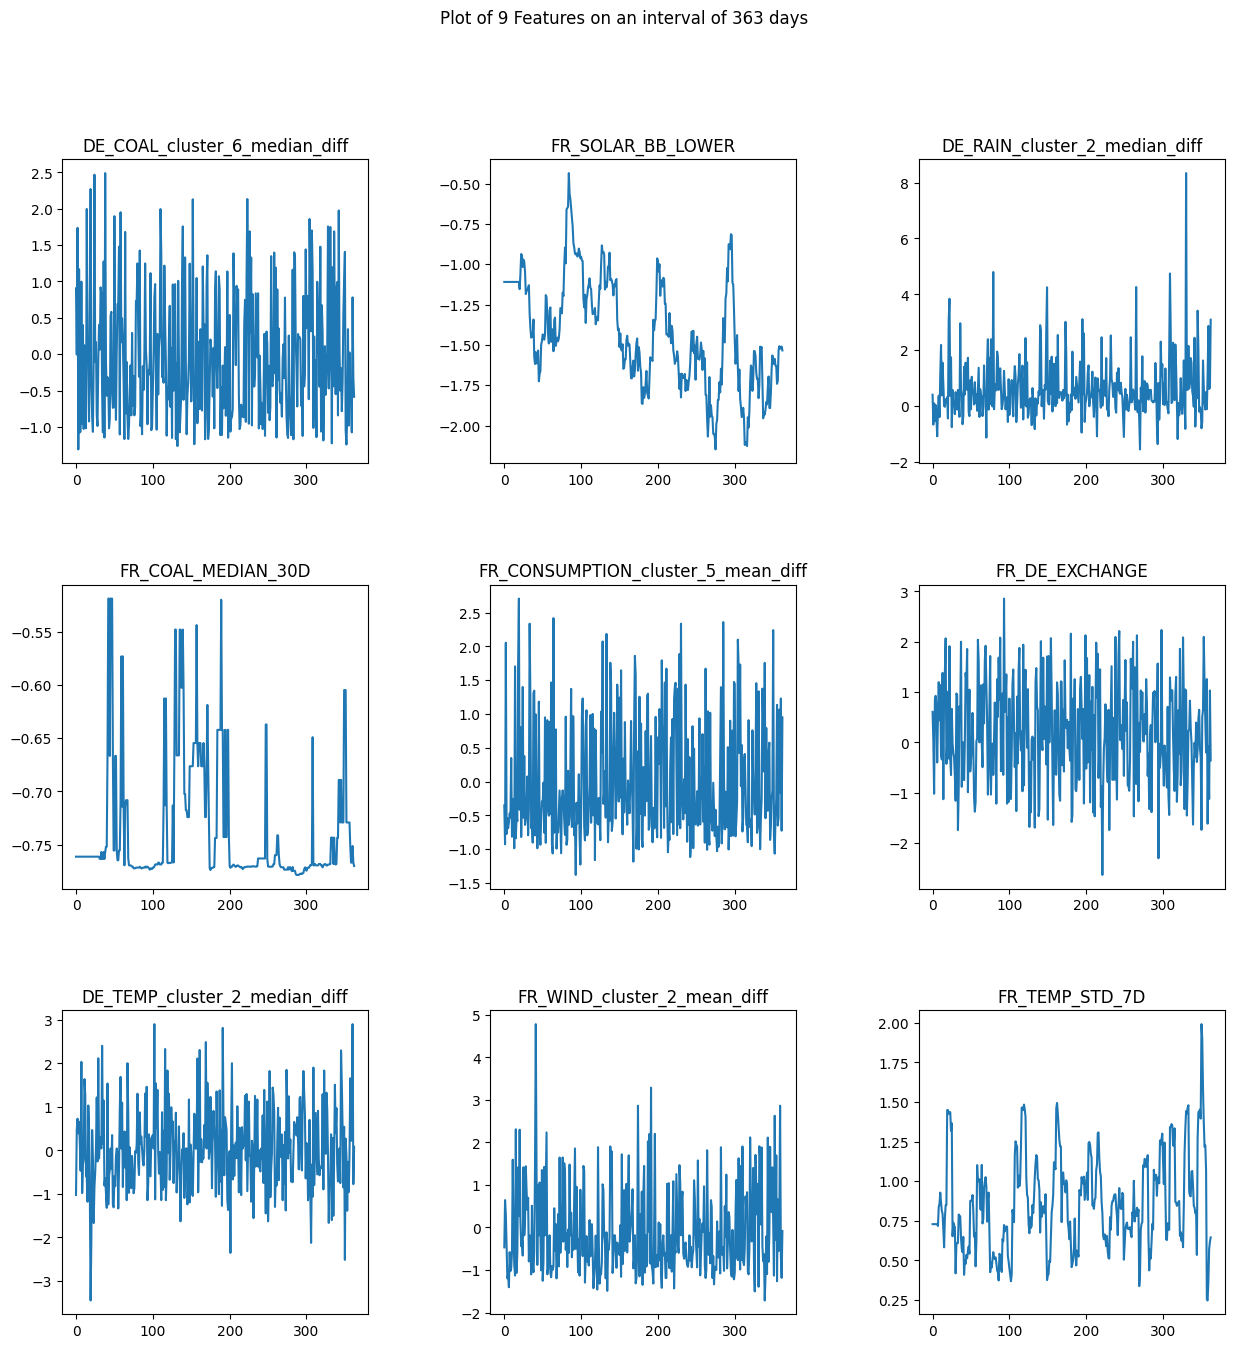

In [10]:
# Print random 9 features to check the stationarity
selected_features = X_featurized.sample(9, axis=1).columns
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Plot of 9 Features on an interval of 363 days')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, feature in enumerate(selected_features):
    row, col = i // 3, i % 3
    axes[row, col].plot(X_featurized[feature].iloc[:363])
    axes[row, col].set_title(feature)

plt.show()

## Model and training

#### *Naive method without any hyperparameter optimization in cross validation in order to find best features*
The general goal here is to get the best features in order to do the optimization of hyper parameter on a reduced space.

In [11]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

X = X_featurized
Y = Y_train['TARGET'].rank(method='average')

params = {
    'loss_function': 'MAE',
    'learning_rate': 0.1,
    'depth': 6,
    'iterations': 1000,
    'verbose': 100,
    'random_seed': 42
}

# Configuration de la validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)
feature_importances = pd.DataFrame(index=X.columns, columns=["Importance"]).fillna(0)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)
    
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)
    
    # Évaluation sur l'ensemble de test
    predictions_test = model.predict(X_test)
    spearman_corr_test = spearmanr(predictions_test, y_test).correlation
    print("Spearman correlation for test data: {:.1f}%".format(100 * spearman_corr_test))
    
    # Mise à jour correcte de l'importance des features
    feature_importance_df = pd.DataFrame(model.get_feature_importance(), index=X.columns, columns=["Importance"])
    feature_importances += feature_importance_df / kf.n_splits

print("Importance of features averaged over CV folds:")
print(feature_importances.sort_values(by="Importance", ascending=False))

Spearman correlation for test data: 18.5%
Spearman correlation for test data: 23.4%
Spearman correlation for test data: 20.9%
Spearman correlation for test data: 27.0%
Spearman correlation for test data: 25.7%
Importance of features averaged over CV folds:
                                  Importance
DE_Imbalance                        2.008326
DE_HYDRO_cluster_8_mean_diff        1.832242
DE_NET_IMPORT                       1.783013
DE_RESIDUAL_LOAD                    1.623288
DE_WINDPOW_cluster_7_mean_diff      1.582149
...                                      ...
FR_WINDPOW_cluster_7_mean_diff      0.000000
DE_WINDPOW_cluster_7_median_diff    0.000000
DE_WINDPOW_SLOPE_7D                 0.000000
DE_WINDPOW_BB_UPPER                 0.000000
FR_WIND_cluster_3_median_diff       0.000000

[802 rows x 1 columns]


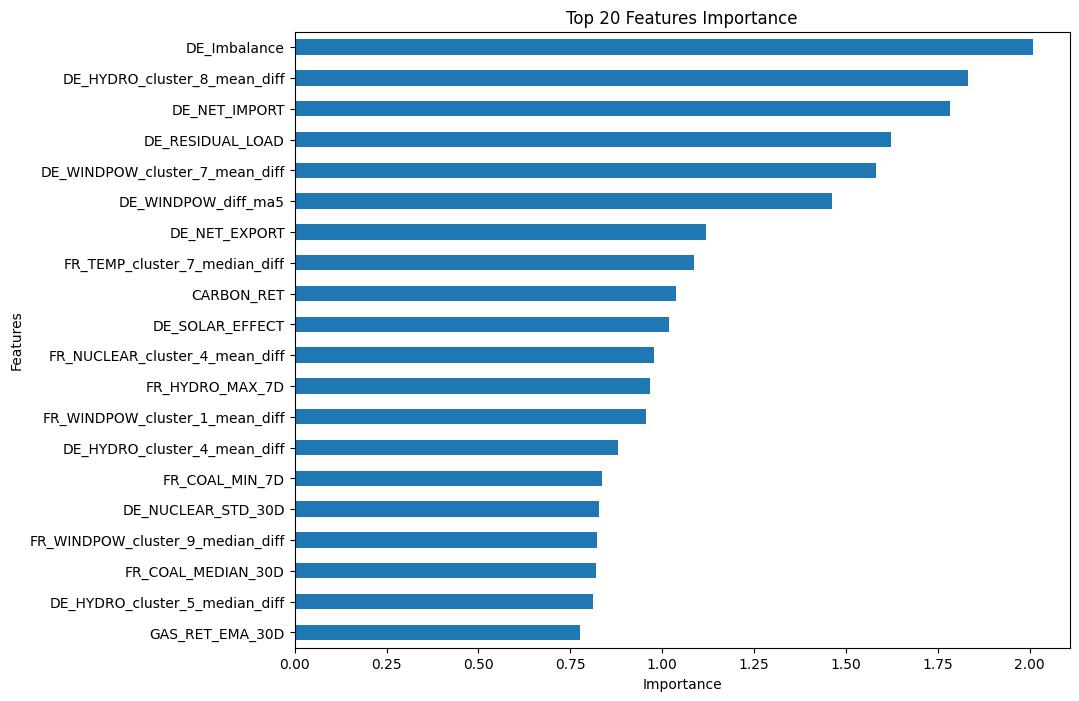

In [12]:
top_features = feature_importances.sort_values(by="Importance", ascending=False).head(20)

# Créer un histogramme des importances des top 20 features
plt.figure(figsize=(10, 8))
top_features['Importance'].plot(kind='barh')
plt.title('Top 20 Features Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher la feature la plus importante en haut
plt.show()

#### Use of GridSearch to find optimal hyperparameters

In [24]:
X = X_featurized
Y = Y_train['TARGET'].rank(method='average')

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
    'iterations': [100, 200, 300],
}

# Configuration du modèle pour la recherche d'hyperparamètres
model = CatBoostRegressor(loss_function='MAE', iterations=200, verbose=False, random_state=42)

# Création du scorer basé sur Spearman Correlation, puisque votre objectif est d'optimiser cela
def spearman_scorer(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

scorer = make_scorer(spearman_scorer, greater_is_better=True)

# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scorer, verbose=2)

# Recherche des meilleurs hyperparamètres sur l'ensemble d'entraînement
X_top_features = X[top_features.index]
grid_search.fit(X_top_features, Y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.0s
[CV] END border_count=32, depth=2, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time

In [15]:
print("Best parameters:", grid_search.best_params_)
print("Best Spearman correlation score:", grid_search.best_score_)

Best parameters: {'border_count': 32, 'depth': 2, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best Spearman correlation score: nan


In [16]:
best_model = grid_search.best_estimator_
dump(best_model, '../models/best_catboost_model.joblib')

['../models/best_catboost_model.joblib']

## Prepare Submission

In [17]:
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

y_test['TARGET_RANK'] = y_test['TARGET'].rank(method='average')

X_featurized_test = feature_engineering(X_test, scaler, False)
X_top_feature_test = X_featurized_test[top_features.index]
predictions_test = best_model.predict(X_top_feature_test)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = predictions_test
Y_test_submission.to_csv('submission_catboost.csv', index=False)